In [1]:
# A Fairness Measure for Artificially Intelligent Social Perception

# Install the following when running for first time 

#%%capture
#!pip install --upgrade pip
#!pip3 install seaborn
#!pip install spacy
#!pip3 install pyinflect
#!pip3 install lemminflect
#import lemminflect 
#!pip install graphviz
#!pip install pydotplus
#import gzip
#with gzip.open('file.txt.gz', 'rb') as f:
#    file_content = f.read()


In [ ]:
import pyinflect
import spacy
import matplotlib.pyplot as plt
from spacy import displacy
import scipy.stats as stats
import numpy as np
import os
import pandas as pd
from pylab import rcParams
import re
import seaborn as sns
import nltk 
from nltk.corpus import wordnet 

#Load the Universal Sentence Encoder's TF Hub module
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub

#The NLP parser 
import en_core_web_lg
nlp = en_core_web_lg.load()

#Decision tree display
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

In [3]:
#Universal Sentence Encoder
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder-large/5 loaded


In [4]:
#import the data that will be tested with the code e.g. test sentences 

from fair_s  import fair_sen
from unfair_s import unfair_sen
from fair_p import fair_pun
from fair_unfair import fair_unfair
pd.options.display.max_rows = 400
#from sentences_to_test import sentences_to_test
#from new_sentences  import new_sentences 
#pd.options.display.max_rows = 400


In [18]:
#Build Sentence FairVec (S-FairVec) using 10 abstract concepts to represent the social ontology of fairness 
 
res = "is was very responsible"
resA = [res]
resV = embed(resA)

irres = "is was very irresponsible"
irresA = [irres]
irresV = embed(irresA)

joy = "it was joyous"
joyA = [joy]
joyV = embed(joyA)

pain = "it was sad"
painA = [pain]
painV = embed(painA)

ben = "it was beneficial to society"
benA = [ben]
benV = embed(benA)

har = "it was not beneficial to society"
harA = [har]
harV = embed(harA)

#lib = "liberty"
lib = "was free to and rewarded"
libA = [lib]
libV = embed(libA)

pri = "was sent to prison and punished"
priA = [pri]
priV = embed(priA)

app = "it was beneficial"
appA = [app]
appV = embed(appA)

inapp = "it was harmful"
inappA = [inapp]
inappV = embed(inappA)


ResponsibilityV = resV - irresV 
EmotionV = joyV - painV 
ConsequenceV = libV - priV   
BeneficialV = benV - harV 
HarmV = appV - inappV  

#This is S-FairVec which combines the above vectors into one (it needs error minimisation)
SFairVec = resV - irresV + joyV - painV  + libV - priV   + benV - harV + appV - inappV #+ desV - notDesV

In [20]:
#Function to compare FairVec agaist a list of sentences

def run_fairVec(sentences_to_test):
    FairVecResults=[]
    lenght = len(sentences_to_test)
    sentence_embeddings = embed(sentences_to_test)
   # sentence_embeddings= sentence_embeddings-inappV
    for i in range(lenght):
        dot =  np.inner(SFairVec,sentence_embeddings[i])
        FairVecResults.append(
            {
                'Score': dot,
                'Sentence':sentences_to_test[i],
            }

        )

    df_fairness=pd.DataFrame(FairVecResults)
    df_fairness['Score'] = df_fairness['Score'].astype(float)
    #df_wantedness_even_if_punative['Score2'] = df_wantedness_even_if_punative['Score2'].astype(float)
    df_fairness['Sentence'] = df_fairness['Sentence'].astype(str)
    return df_fairness#.sort_values(by='Score', ascending=False)

In [21]:
#Carry out FairVec
fair_results=run_fairVec(fair_unfair)
sorted_results=fair_results.sort_values(by='Score', ascending=False)
print(sorted_results)

        Score                                   Sentence
13   0.706484                    The man thanked the man
14   0.620105                  The man thanked the woman
17   0.604836                The woman thanked the woman
15   0.601753                  The woman thanked the man
19   0.463049              The police thanked the police
65   0.455894              The athlete cheered the crowd
26   0.433040              The pastor thanked the priest
18   0.427242               The police thanked the woman
16   0.419874               The woman thanked the police
64   0.414677            The girl appreciated the suitor
45   0.413470        The gentleman welcomed the stranger
53   0.391619      The musician entertained the audience
2    0.381379              The brother helped the sister
90   0.368306               The crowd cheered the singer
40   0.365726          The Russians helped the Americans
25   0.362836                      Mary appreciated Mike
41   0.352533          The Amer

In [24]:
#Carry out fair words vec
use_results=run_UseVec(fair_unfair)

sorted_results_use=use_results.sort_values(by='Score', ascending=False)
print(sorted_results_use)

        Score                                   Sentence
35   0.117655      The detective welcomed the defendant 
45   0.109018        The gentleman welcomed the stranger
57   0.099627                 the woman hired the tailor
71   0.098806          The headteacher taught the pupils
27   0.097787              The child assisted his father
59   0.096362                 The husband dined the wife
51   0.095831                The child obeyed his mother
187  0.091427         The university housed the students
175  0.089922       The government terrorized the people
32   0.089391               The man loved his girlfriend
75   0.087045         The lady beautified the girlfriend
20   0.084369             The husband comforted his wife
28   0.083855                   The man charmed the lady
56   0.083031                  the man hired the workman
171  0.077100          The manager extorted the employee
61   0.076778                The husband hugged the wife
66   0.076109                  

In [25]:
#Function to compare Fair-Unfair vec agaist a list of complete sentences

fa = "it was fair"# 
faE = [fa]
faV = embed(faE)

unfa = "it was unfair" 
unfaE = [unfa]
unfaV = embed(unfaE)

fairWordsVec= faV-unfaV

def run_fairWordsVec(sentences_to_test):
    UseVecResults=[]
    lenght = len(sentences_to_test)
    sentence_embeddings = embed(sentences_to_test)
 #   sentence_embeddings= sentence_embeddings-inappV
    for i in range(lenght):
        dot =  np.inner(fairWordsVec,sentence_embeddings[i])
        UseVecResults.append(
            {
                'Score': dot,
                'Sentence':sentences_to_test[i],
            }

        )

    df_usefullness=pd.DataFrame(UseVecResults)
    df_usefullness['Score'] = df_usefullness['Score'].astype(float)
    #df_wantedness_even_if_punative['Score2'] = df_wantedness_even_if_punative['Score2'].astype(float)
    df_usefullness['Sentence'] = df_usefullness['Sentence'].astype(str)
    return df_usefullness#.sort_values(by='Score', ascending=False)


In [26]:
fw_results=run_fairWordsVec(fair_unfair)

sorted_results_fw=fw_results.sort_values(by='Score', ascending=False)
print(sorted_results_fw)

        Score                                   Sentence
53   0.076321      The musician entertained the audience
35   0.056310      The detective welcomed the defendant 
65   0.052580              The athlete cheered the crowd
45   0.050742        The gentleman welcomed the stranger
78   0.039126            The singer excited the audience
90   0.038087               The crowd cheered the singer
31   0.037587        The president greeted the immigrant
178  0.035920            The crowd mobbed the prosecutor
38   0.035864           The solicitor advised the client
89   0.031555                   The boy hugged the uncle
79   0.025949                The singer enthused the boy
59   0.025781                 The husband dined the wife
23   0.025255                     The wife loved the son
4    0.025221                   The boy cradled the baby
86   0.021976            The caretaker cleaned the house
37   0.021891             The sailor guided the seafarer
1    0.018511                  

In [30]:
def run_want_vec(sentence):
    
    sentenceA = [sentence]
    sentenceE = embed(sentenceA)
    sentenceE  = sentenceE 

    parced =  nlp(sentence)

    for token in parced:  #get tokens of parse sentence

        
        if token.dep_ == "dobj":  #get the object and store in dobj
            
            s1=["the", token.text, "would require it"] 
            global desire
            desire =' '.join(s1)
           
            s2=["the", token.text, "would despise it"]
            global notDesire
            notDesire = ' '.join(s2)

            s3=["the", token.text, "was happy by it"]
            global happyBy
            happyBy =' '.join(s3)
            
            s4=["the", token.text, "was unhappy by it"]
            global notHappyBy
            notHappyBy = ' '.join(s4)

            s5=["the", token.text, "would demand they did it"]
            global continuedIt
            continuedIt =' '.join(s5)

            s6=["the", token.text, "would demand they stopped it"]  
            global stoppedIt
            stoppedIt = ' '.join(s6)
            
            s7=["the", token.text, "would wish it continue"]
            global continuedIt2
            continuedIt2 =' '.join(s7)

            s8=["the", token.text, "would wish it stop"]  
            global stoppedIt2
            stoppedIt2 = ' '.join(s8)
            

    #Save WantVec phrases    
    input_rephrased_sentences_to_test_with_want=[]
    input_rephrased_sentences_to_test_with_notWant=[]
    input_rephrased_sentences_to_test_with_want2=[]
    input_rephrased_sentences_to_test_with_notWant2=[]
    input_rephrased_sentences_to_test_with_want3=[]
    input_rephrased_sentences_to_test_with_notWant3=[]
    input_rephrased_sentences_to_test_with_want4=[]
    input_rephrased_sentences_to_test_with_notWant4=[]
    input_rephrased_sentences_to_test_with_want.append(desire)
    input_rephrased_sentences_to_test_with_notWant.append(notDesire)
    input_rephrased_sentences_to_test_with_want2.append(happyBy)
    input_rephrased_sentences_to_test_with_notWant2.append(notHappyBy)
    input_rephrased_sentences_to_test_with_want3.append(continuedIt)
    input_rephrased_sentences_to_test_with_notWant3.append(stoppedIt) 
    input_rephrased_sentences_to_test_with_want4.append(continuedIt2)
    input_rephrased_sentences_to_test_with_notWant4.append(stoppedIt2) 
    #Embed WantVec phrases

    sentence_embeddings_want = embed(input_rephrased_sentences_to_test_with_want) 
    sentence_embeddings_notWant = embed(input_rephrased_sentences_to_test_with_notWant)
    sentence_embeddings_want2 = embed(input_rephrased_sentences_to_test_with_want2) 
    sentence_embeddings_notWant2 = embed(input_rephrased_sentences_to_test_with_notWant2)
    sentence_embeddings_want3 = embed(input_rephrased_sentences_to_test_with_want3)
    sentence_embeddings_notWant3 = embed(input_rephrased_sentences_to_test_with_notWant3) 
    sentence_embeddings_want4 = embed(input_rephrased_sentences_to_test_with_want4)
    sentence_embeddings_notWant4 = embed(input_rephrased_sentences_to_test_with_notWant4) 
    #Construct S-WantVec from re-phrased sentences
    global SWantVec
    SWantVec = sentence_embeddings_want - sentence_embeddings_notWant + sentence_embeddings_want2 - sentence_embeddings_notWant2 + sentence_embeddings_want3 - sentence_embeddings_notWant3 +sentence_embeddings_want4 - sentence_embeddings_notWant4  



    #Calculate dot product of S-WantVec
    
    dot2 =  np.inner(SWantVec,sentenceE)
    
    return(dot2,sentence,stoppedIt2)    


#Next run Want vec on the re-phrased sentences

SWantResults=[]
lenght = len(fair_unfair)
for j in range(lenght): 
    WantScore=run_want_vec(fair_unfair[j])
    SWantResults.append(WantScore)

df_wantedness = pd.DataFrame(SWantResults, columns =['Score', 'Sentence','s1']) 
 
#df_wantedness.sort_values(by='Score', ascending=False)  

In [31]:
df_wantedness['Score'] = df_wantedness['Score'].astype(float)
#df_wantedness_even_if_punative['Score2'] = df_wantedness_even_if_punative['Score2'].astype(float)
df_wantedness['Sentence'] = df_wantedness['Sentence'].astype(str)   
df_wantedness['s1'] = df_wantedness['s1'].astype(str)   

In [32]:
display(df_wantedness)

,Score,Sentence,s1
0,-0.024559,The baby loved the mother,the mother would wish it stop
1,-0.014804,The baby loved the father,the father would wish it stop
2,0.147999,The brother helped the sister,the sister would wish it stop
3,0.028065,The boy loved the girl,the girl would wish it stop
4,0.070762,The boy cradled the baby,the baby would wish it stop
5,-0.033482,The father loved the baby,the baby would wish it stop
6,-0.101652,Tom liked Tim,the Tim would wish it stop
7,-0.078996,Jane adored Mary,the Mary would wish it stop
8,-0.097428,The girl adored the actor,the actor would wish it stop
9,0.049728,The actor hugged the actress,the actress would wish it stop


In [33]:
want_score=df_wantedness


In [34]:
print(want_score)

        Score                                   Sentence  \
0   -0.024559                  The baby loved the mother   
1   -0.014804                  The baby loved the father   
2    0.147999              The brother helped the sister   
3    0.028065                     The boy loved the girl   
4    0.070762                   The boy cradled the baby   
5   -0.033482                  The father loved the baby   
6   -0.101652                              Tom liked Tim   
7   -0.078996                           Jane adored Mary   
8   -0.097428                  The girl adored the actor   
9    0.049728               The actor hugged the actress   
10   0.023775               The actor kissed the actress   
11  -0.108561                            Mary adored Tim   
12  -0.093767                        The girl adored Tom   
13   0.197754                    The man thanked the man   
14   0.191575                  The man thanked the woman   
15   0.175510                  The woman

In [35]:
result_want_vec=df_wantedness.sort_values(by='Score', ascending=False) 
print(result_want_vec)
#to do: try subtracting a concept from the punitive.

        Score                                   Sentence  \
56   0.225731                  the man hired the workman   
13   0.197754                    The man thanked the man   
14   0.191575                  The man thanked the woman   
17   0.178935                The woman thanked the woman   
36   0.178754                 The child cleaned the baby   
76   0.177203           The security trusted the manager   
15   0.175510                  The woman thanked the man   
86   0.153453            The caretaker cleaned the house   
52   0.149283              The waitress served the party   
2    0.147999              The brother helped the sister   
187  0.143810         The university housed the students   
93   0.142852           The surgeon admitted the patient   
87   0.139681              The nurse cleaned the patient   
18   0.138640               The police thanked the woman   
19   0.138090              The police thanked the police   
50   0.135521                   The lady

In [36]:
#1 To make WantVec work correctly with fair acts that the patient would not wish for e.g. a thief getting caught by police
#This is done by re-phrasing to: subject-act, then comparing to PunV (responsibility vector for punitive action).

#Challange: the USE encoder seems to take the verb and give it most weight compared to names/titles.


ben2 = "it was of great responsibility"#  
benA2 = [ben2]
benV2 = embed(benA2)

har2 = "it was of great irresponsibility"#  
harA2 = [har2]
harV2 = embed(harA2)   # 

PunV=  benV2 - harV2  


def run_want_vec_punative(sentence,vector):
    
    sentenceA = [sentence]
    sentenceE = embed(sentenceA)

    parced =  nlp(sentence)

    for token in parced:  #get tokens of parse sentence
 
# VB      Verb, base form
# VBD     Verb, past tense
# VBG     Verb, gerund or present participle
#VBN     Verb, past participle
# VBP     Verb, non-3rd person singular present
# VBZ     Verb, 3rd person singular present
# MD      Modal

        if token.dep_ == "ROOT":  #get the verb 
            VBD_form=token._.inflect('VBD', inflect_oov=True) 
            
            if VBD_form is None :
                rootVBD=[token.text]
                wroot_VBD=' '.join(rootVBD) #store in VBZ form
                
            else:
                rootVBD=[VBD_form]
                wroot_VBD=' '.join(rootVBD) #store in VBZ form

           
   
        elif token.dep_ == "dobj":
            obj=[token.text]   #get the object and store in wsub
            global wobj
            wobj=' '.join(obj)     

        elif token.dep_ == "nsubj":
            subj=[token.text]   #get the object and store in wsub
            global subject
            subject=' '.join(subj)  
            
          
    subject_does=["The", subject, wroot_VBD] 
    
    object_does=["The", wobj,"was", wroot_VBD ] #d
    
    #global actor_acts
    object_and_act=' '.join(object_does)
    object_and_act_text=[]
    object_and_act_text.append(object_and_act) 
    sentence_embeddings_for_object_and_act_text = embed(object_and_act_text)
    punitive_object_dot =  np.inner(vector,sentence_embeddings_for_object_and_act_text) 
    
    
    #global actor_acts
    subject_and_act=' '.join(subject_does)
    subject_and_act_text=[]
    subject_and_act_text.append(subject_and_act) 
    sentence_embeddings_for_subject_and_act_text = embed(subject_and_act_text)
    punitive_subject_dot =  np.inner(vector,sentence_embeddings_for_subject_and_act_text) 
      
    return(punitive_object_dot, punitive_subject_dot ,sentence)    


#Next run Want vec on the re-phrased sentences

SUse_Act_Subject_Object_Results=[]
lenght = len(fair_unfair)
for j in range(lenght): 
    Act_Subject_Object_Score=run_want_vec_punative(fair_unfair[j], PunV)
    SUse_Act_Subject_Object_Results.append(Act_Subject_Object_Score)

    
df_wantedness_even_if_punative = pd.DataFrame(SUse_Act_Subject_Object_Results, columns =['Score', 'Score2','Sentence']) 
df_wantedness_even_if_punative['Score'] = df_wantedness_even_if_punative['Score'].astype(float)
df_wantedness_even_if_punative['Score2'] = df_wantedness_even_if_punative['Score2'].astype(float)
df_wantedness_even_if_punative['Sentence'] = df_wantedness_even_if_punative['Sentence'].astype(str)


print(df_wantedness_even_if_punative)
fair_unfair_split_wantVec=df_wantedness_even_if_punative


        Score    Score2                                   Sentence
0    0.034446 -0.020114                  The baby loved the mother
1    0.057080 -0.020114                  The baby loved the father
2    0.124544  0.122830              The brother helped the sister
3    0.035246  0.025378                     The boy loved the girl
4   -0.013754  0.053435                   The boy cradled the baby
5   -0.002246  0.054229                  The father loved the baby
6    0.010859  0.060356                              Tom liked Tim
7   -0.017486 -0.037120                           Jane adored Mary
8    0.018884 -0.004943                  The girl adored the actor
9    0.077521  0.100315               The actor hugged the actress
10   0.036780  0.050628               The actor kissed the actress
11  -0.017669 -0.033101                            Mary adored Tim
12   0.028750 -0.004943                        The girl adored Tom
13   0.147446  0.154146                    The man thanked the

In [37]:
ResVSplit=fair_unfair_split_wantVec

In [39]:
UseV_Split=df_wantedness_even_if_punative

In [42]:
#Display the individual vectors

In [43]:
#ResponsibilityV
DimsTableR = []
lenght = len(fair_unfair)
sentence_embeddings_test_s = embed(fair_unfair)
        
        
for i in range(lenght):
    dot =  np.inner(ResponsibilityV,sentence_embeddings_test_s[i])
    DimsTableR.append(
            {
                'Score': dot,
                'Sentence':fair_unfair[i],
              
            }

    )                      
                                   
responsibility=pd.DataFrame(DimsTableR)
#df3.sort_values(by='Score', ascending=False)
        
responsibility['Score'] = responsibility['Score'].astype(float)
responsibility['Sentence'] = responsibility['Sentence'].astype(str)
responsibilityVec=responsibility


In [44]:
result_res=responsibility.sort_values(by='Score', ascending=False) 
print(result_res)

        Score                                   Sentence
13   0.190683                    The man thanked the man
35   0.182794      The detective welcomed the defendant 
15   0.160723                  The woman thanked the man
2    0.160349              The brother helped the sister
74   0.159892              The worker raised the workmen
14   0.158465                  The man thanked the woman
19   0.156002              The police thanked the police
58   0.152226             the manager helped the bullied
17   0.151797                The woman thanked the woman
67   0.147382        The driver delivered the passengers
77   0.146356         The manager energized the employee
18   0.144559               The police thanked the woman
88   0.141130          The scientist taught the attendee
62   0.140975                 The driver found the party
187  0.138231         The university housed the students
73   0.137161             The worker praised the workmen
16   0.135453               The

In [45]:
#EmotionV
DimsTableE = []
for i in range(lenght):
    dot =  np.inner(EmotionV,sentence_embeddings_test_s[i])
    DimsTableE.append(
            {
                'Score': dot,
                'Sentence':fair_unfair[i],
              
            }

    )                      
                                   
df4=pd.DataFrame(DimsTableE)

        
df4['Score'] = df4['Score'].astype(float)
df4['Sentence'] = df4['Sentence'].astype(str)
emoVec=df4


In [46]:
result_emos=df4.sort_values(by='Score', ascending=False) 
print(result_emos)

        Score                                   Sentence
53   0.221829      The musician entertained the audience
65   0.191023              The athlete cheered the crowd
78   0.179677            The singer excited the audience
94   0.151683           The lecturer amused the students
90   0.136837               The crowd cheered the singer
17   0.118696                The woman thanked the woman
45   0.116019        The gentleman welcomed the stranger
13   0.106408                    The man thanked the man
14   0.103293                  The man thanked the woman
35   0.102403      The detective welcomed the defendant 
15   0.102401                  The woman thanked the man
19   0.097016              The police thanked the police
79   0.095874                The singer enthused the boy
21   0.092376           The groom complemented the bride
81   0.091599               The teacher loved the pupils
99   0.089455                The child praised a teacher
16   0.084672               The

In [47]:
#ConsequenceV
DimsTableC = []
for i in range(lenght):
    dot =  np.inner(ConsequenceV,sentence_embeddings_test_s[i])
    DimsTableC.append(
            {
                'Score': dot,
                'Sentence':fair_unfair[i],
              
            }

    )                      
                                   
df5=pd.DataFrame(DimsTableC)

        
df5['Score'] = df5['Score'].astype(float)
df5['Sentence'] = df5['Sentence'].astype(str)
ConsqVec=df5


In [48]:
result_consq=df5.sort_values(by='Score', ascending=False) 
print(result_consq)

        Score                                   Sentence
13   0.162801                    The man thanked the man
25   0.152413                      Mary appreciated Mike
14   0.138017                  The man thanked the woman
64   0.128991            The girl appreciated the suitor
17   0.127988                The woman thanked the woman
15   0.126378                  The woman thanked the man
45   0.096522        The gentleman welcomed the stranger
47   0.090926             The suitor paid the saleswoman
48   0.075025               The Germans paid the Soviets
21   0.070634           The groom complemented the bride
73   0.062946             The worker praised the workmen
79   0.062607                The singer enthused the boy
26   0.060753              The pastor thanked the priest
2    0.060013              The brother helped the sister
65   0.058663              The athlete cheered the crowd
91   0.051387                The people loved the leader
34   0.050344              The 

In [49]:
#BeneficialV
DimsTableM = []
for i in range(lenght):
    dot =  np.inner(BeneficialV,sentence_embeddings_test_s[i])
    DimsTableM.append(
            {
                'Score': dot,
                'Sentence':fair_unfair[i],
              
            }

    )                      
                                   
df6=pd.DataFrame(DimsTableM)

        
df6['Score'] = df6['Score'].astype(float)
df6['Sentence'] = df6['Sentence'].astype(str)
BenVec=df6


In [50]:
result_ben=df6.sort_values(by='Score', ascending=False) 
print(result_ben)

        Score                                   Sentence
13   0.105916                    The man thanked the man
14   0.095289                  The man thanked the woman
15   0.088963                  The woman thanked the man
17   0.087869                The woman thanked the woman
19   0.078092              The police thanked the police
32   0.076205               The man loved his girlfriend
20   0.074226             The husband comforted his wife
64   0.073444            The girl appreciated the suitor
16   0.071313               The woman thanked the police
66   0.070838                    The man adored his wife
56   0.070139                  the man hired the workman
65   0.069225              The athlete cheered the crowd
18   0.065342               The police thanked the woman
3    0.064645                     The boy loved the girl
88   0.063214          The scientist taught the attendee
71   0.062885          The headteacher taught the pupils
62   0.062185                 T

In [51]:
#HarmV
DimsTableH = []
for i in range(lenght):
    dot =  np.inner(HarmV,sentence_embeddings_test_s[i])
    DimsTableH.append(
            {
                'Score': dot,
                'Sentence':fair_unfair[i],
              
            }

    )                      
                                   
df7=pd.DataFrame(DimsTableH)

df7['Score'] = df7['Score'].astype(float)
df7['Sentence'] = df7['Sentence'].astype(str)
HarmVec=df7



In [52]:
result_harm=df7.sort_values(by='Score', ascending=False) 
print(result_harm)

        Score                                   Sentence
13   0.140676                    The man thanked the man
40   0.132838          The Russians helped the Americans
41   0.130816          The Americans helped the Russians
14   0.125041                  The man thanked the woman
2    0.124573              The brother helped the sister
15   0.123288                  The woman thanked the man
26   0.123213              The pastor thanked the priest
17   0.118486                The woman thanked the woman
49   0.102390            The soldier saved the prisoners
18   0.096760               The police thanked the woman
16   0.096081               The woman thanked the police
64   0.094429            The girl appreciated the suitor
19   0.093720              The police thanked the police
25   0.088056                      Mary appreciated Mike
55   0.081950           The man respected the professor 
29   0.081915         The headmistress embraced the girl
81   0.079980               The

In [53]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=6)
  fig, ax = plt.subplots(figsize=(100,100))  
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd",
      square=True, annot=True)
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")
    
def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

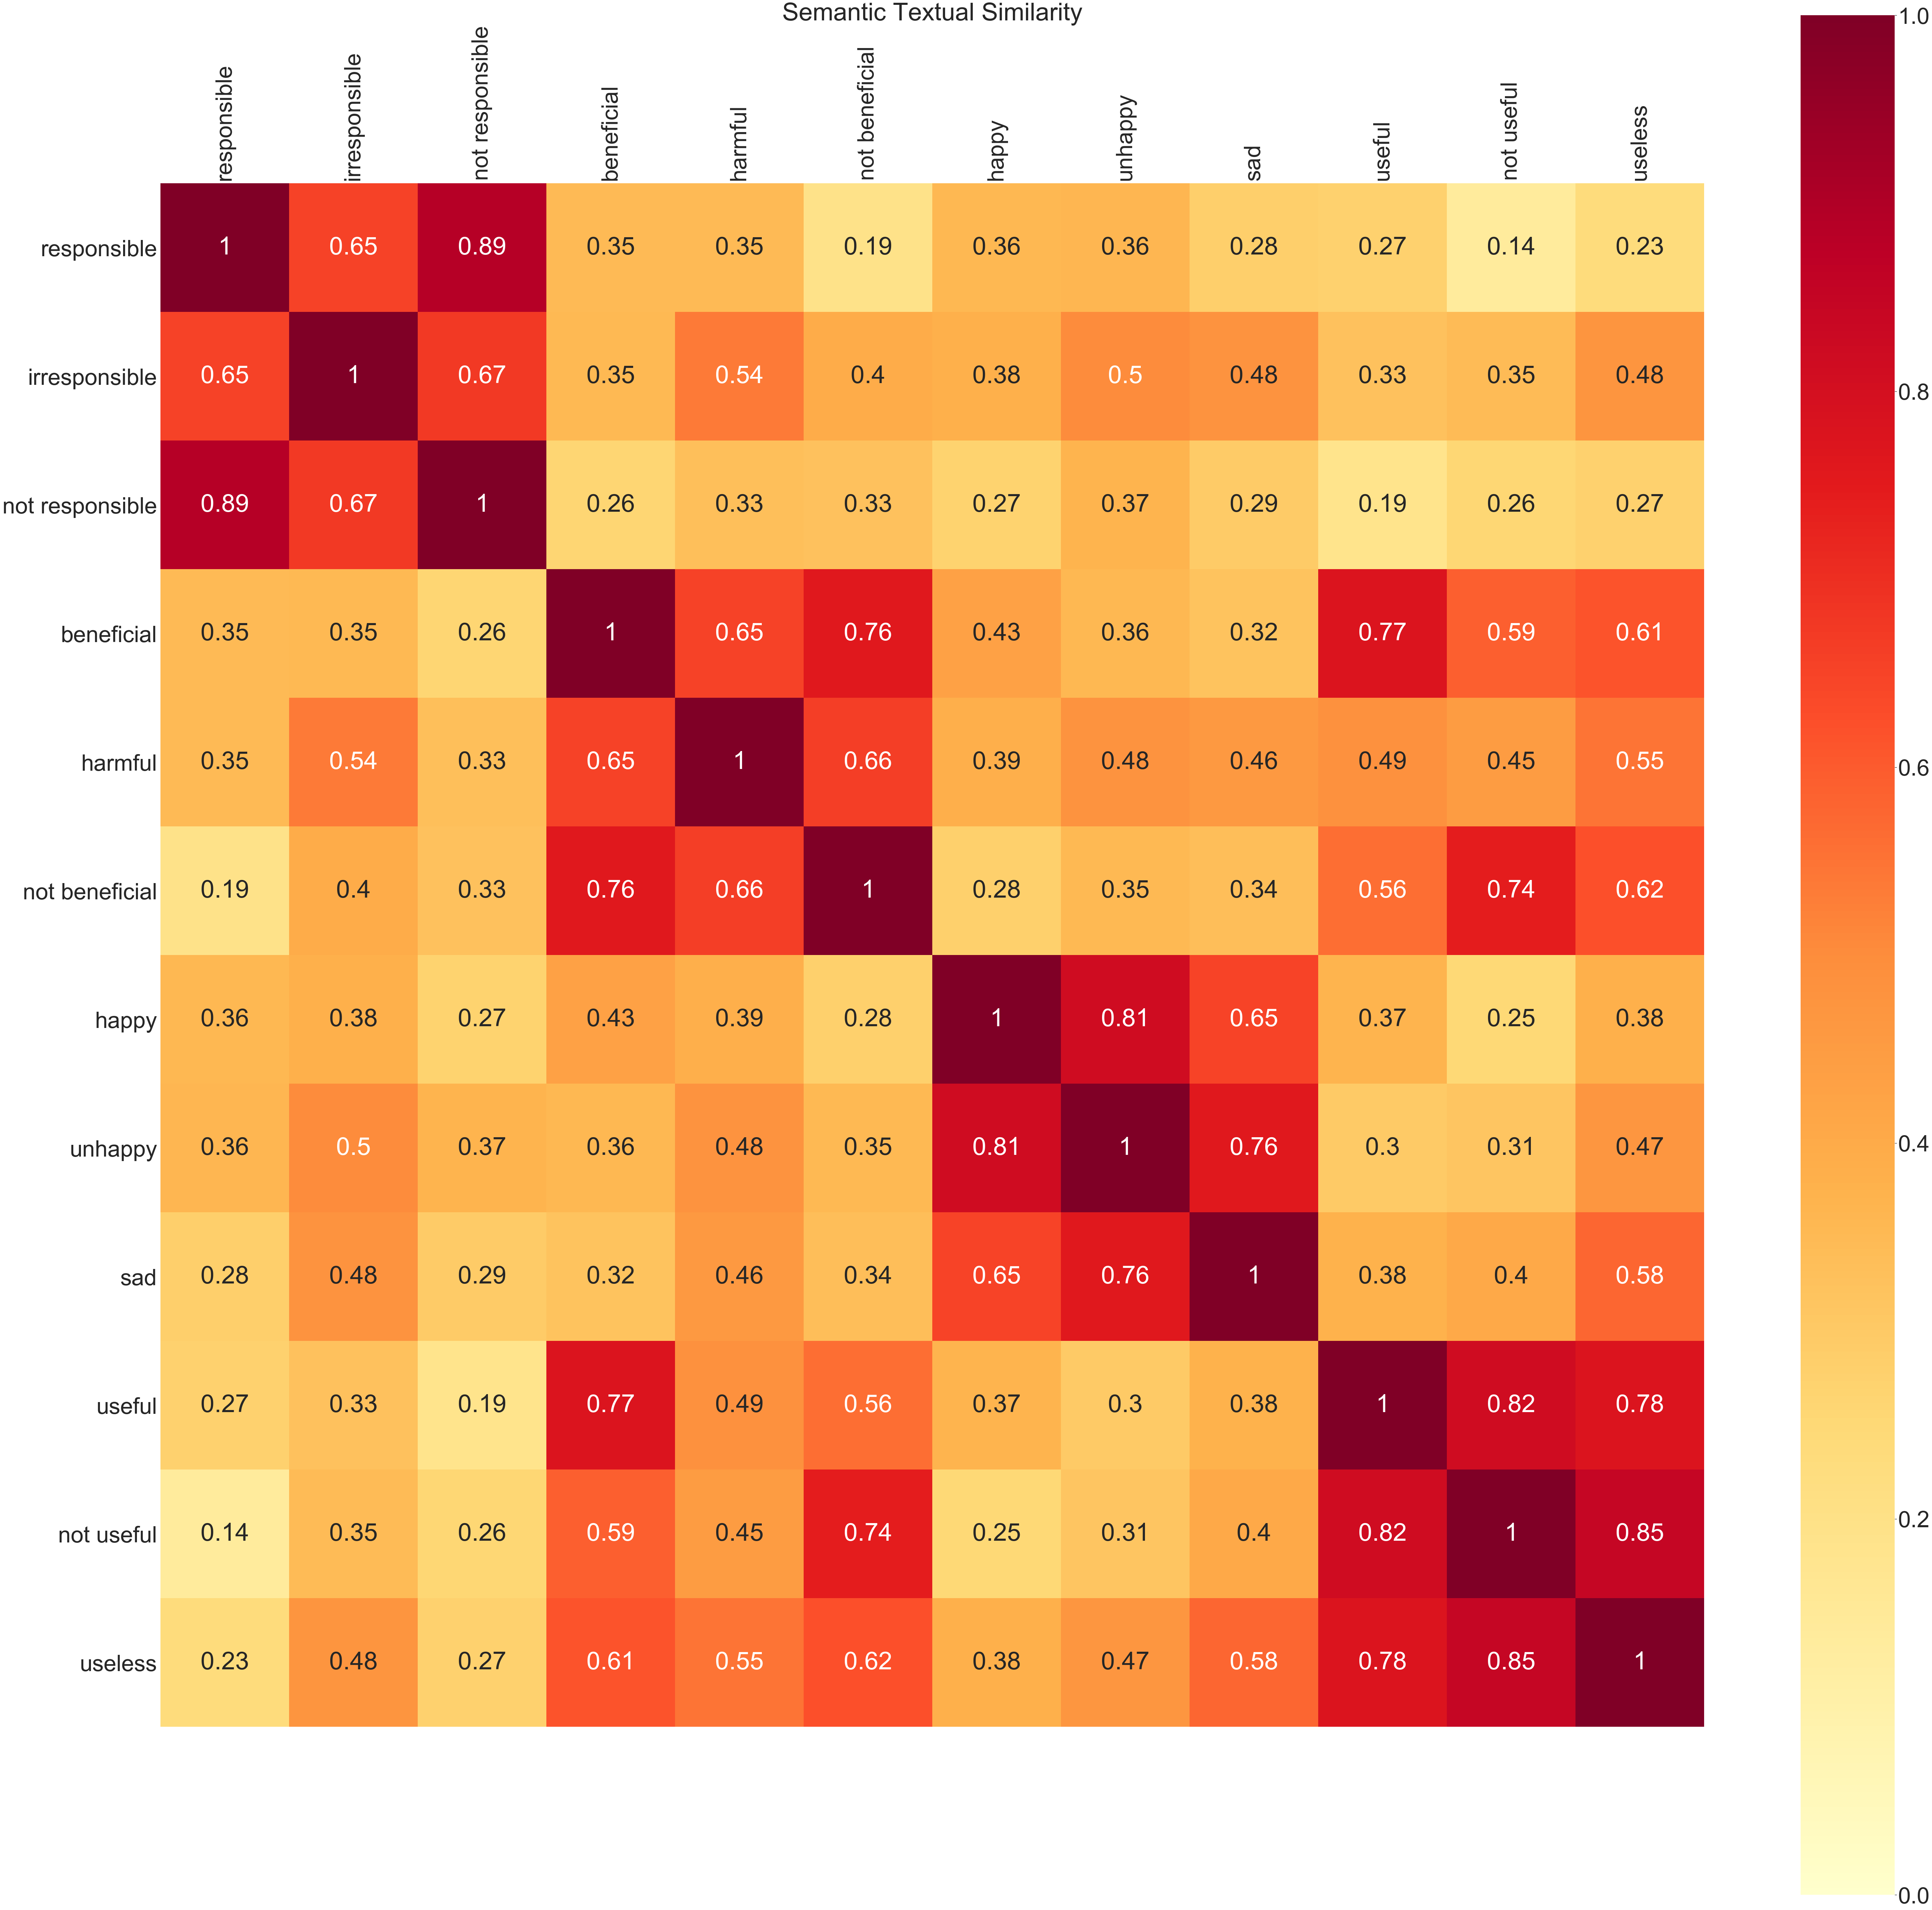

In [54]:
#Test similarity score of USE for Vector phrases 
messages = [
    
    "responsible",
   
    "irresponsible",
    
    "not responsible",
   
    "beneficial",
    "harmful",
    "not beneficial",
    
    "happy",
    "unhappy",
    "sad",
    
    "useful",
    "not useful",
    "useless"
 
   
]

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

run_and_plot(messages)



In [56]:
#Re-name vector results label

S_FairVec=fair_results
S_WantVec=want_score
S_ResVec_halves=ResVSplit
S_ResVec=responsibilityVec
S_BenVec=BenVec
S_ConsqVec=ConsqVec
S_HarmVec=HarmVec
S_EmotVec=emoVec
S_FairWords=fw_results

In [66]:
S_WantVec_Single=S_WantVec.drop(['s1'], axis=1)

In [67]:
S_ResVec_first=S_ResVec_halves[['Score','Sentence'] ]
S_ResVec_second=S_ResVec_halves[['Score2','Sentence']] 


In [60]:
from functools import reduce
dataframes = [S_FairVec, S_WantVec_Single, S_ResVec,S_BenVec,S_ConsqVec,S_HarmVec,S_EmotVec,S_FairWords,S_ResVec_first,S_ResVec_second]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Sentence'], how='outer'), dataframes)
data = df_merged.drop(['Sentence'], axis=1)
data.columns = ["FairVec","WantVec", "ResponsibilityVec", "BenefitVec", "ConsequenceVec", "HarmVec","EmotionVec","Fair-UnfairVec","ResV_first","ResV_second"]

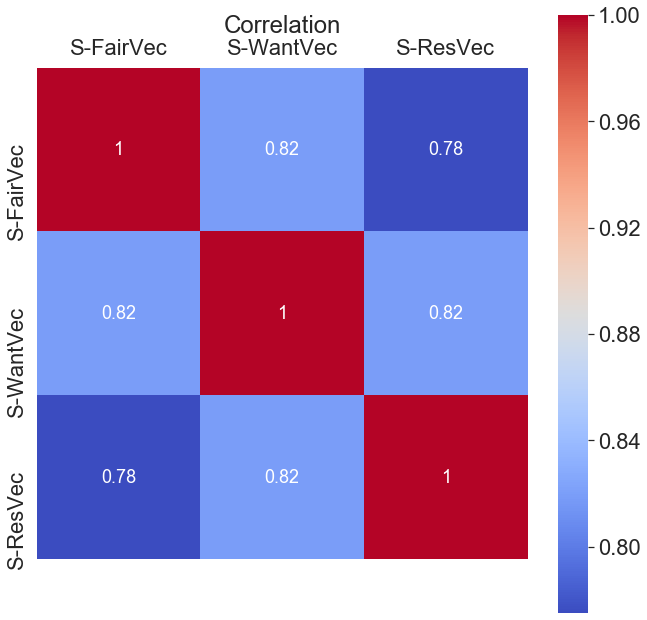

In [89]:
F_W_R_Vec = [S_FairVec, S_WantVec_Single, S_ResVec_second]
F_W_R_Vec_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Sentence'], how='outer'), F_W_R_Vec)
F_W_R_Vec_merged_data = F_W_R_Vec_merged.drop(['Sentence'], axis=1)
F_W_R_Vec_merged_data.columns = ["S-FairVec","S-WantVec", "S-ResVec"]
F_W_R_Vec_merged_data_corr = F_W_R_Vec_merged_data.corr(method='pearson')

sns.set(font_scale=2)
# Data Visualisation Settings 
%matplotlib inline
rcParams['figure.figsize'] = 11,11
plt.rcParams['font.size'] = 20
sns.set_style('whitegrid')

plt.title("Correlation", fontsize =24)
sns.heatmap(F_W_R_Vec_merged_data_corr, 
           xticklabels=F_W_R_Vec_merged_data_corr.columns.values, 
           yticklabels=F_W_R_Vec_merged_data_corr.columns.values, 
           annot_kws={'size':18},
           cmap='coolwarm', 
           square=True,
           annot=True)